In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [48]:
# Create an EV class with the following attributes:
# - Brand
# - Model
# - Battery type
# - Battery size
# - Charging Efficiency
# - Discharging Efficiency
# - Energy per km
# - SOC min
# - SOC max
# - Probability in population - this is the probability that a car of this type will be chosen from the population

class EV:
    def __init__(self, brand, model, battery_type, battery_size, charging_efficiency, discharging_efficiency, energy_per_km, soc_min, soc_max, probability_in_population):
        self.brand = brand
        self.model = model
        self.battery_type = battery_type
        self.battery_size = battery_size
        self.charging_efficiency = charging_efficiency if charging_efficiency <= 1 or charging_efficiency >= 0 else 0.9
        self.discharging_efficiency = discharging_efficiency if discharging_efficiency <= 1 or discharging_efficiency >= 0 else 0.9
        self.energy_per_km = energy_per_km
        self.soc_min = soc_min if soc_min >= 0.0 else 0.0
        self.soc_max = soc_max if soc_max <= 1.0 else 1.0
        self.probability_in_population = probability_in_population if probability_in_population <= 1.0 else 1.0


# Extend the class to create drivable EVs
class DrivableEV(EV):

    # __init__ method is inherited from EV class, extended with the state of charge. Creates the following attributes:
    # - State of Charge
    # - List of trips
    # - Current trip
    def __init__(self, brand, model, battery_type, battery_size, charging_efficiency, discharging_efficiency, energy_per_km, soc_min, soc_max, probability_in_population, initial_soc=None):
        super().__init__(brand, model, battery_type, battery_size, charging_efficiency, discharging_efficiency, energy_per_km, soc_min, soc_max, probability_in_population)

        # SOC variables
        self.soc = [initial_soc]
        self.current_soc = initial_soc

        # List of trips and current trip
        self.trips = []
        self.current_trip = None

        # Information about the charging stations
        self.current_charging_station = None


    # Format the print
    def __repr__(self):
        return f"{self.brand} {self.model} with {self.battery_size} kWh battery"

    # Create a method to add a trip to the EV
    def add_trip(self, trip):
        self.trips.append(trip)
        self.current_trip = trip


    # Create a method to charge the EV
    def charge(self, charge_amount):
        self.current_soc += charge_amount * self.charging_efficiency

        if self.current_soc > self.battery_size:
            self.current_soc = self.battery_size


    # Create a method to discharge the EV
    def discharge(self, discharge_amount):
        self.current_soc -= discharge_amount * self.discharging_efficiency

        if self.current_soc < 0:
            self.current_soc = 0

In [49]:
# Create a list of EVs to use in the simulation

EVs = [EV(brand='Nissa', model='Leaf', battery_type='BEV', battery_size=40,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.16, energy_per_km=0.2, soc_min=0.7, soc_max=1.0),
       EV(brand='Tesla', model='Model 3', battery_type='BEV', battery_size=75,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.13, energy_per_km=0.2, soc_min=0.7, soc_max=1.0),
       EV(brand='BMW', model='i3', battery_type='BEV', battery_size=42,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.1, energy_per_km=0.2, soc_min=0.7, soc_max=1.0),
       EV(brand='Renault', model='Zoe', battery_type='BEV', battery_size=41,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.1, energy_per_km=0.2, soc_min=0.7, soc_max=1.0),
       EV(brand='Jaguar', model='I-Pace', battery_type='BEV', battery_size=90,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.09, energy_per_km=0.2, soc_min=0.7, soc_max=1.0),
       EV(brand='Mercedes', model='E300', battery_type='PHEV', battery_size=135,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.08, energy_per_km=0.2, soc_min=0.7, soc_max=1.0),
       EV(brand='BMW', model='530e', battery_type='PHEV', battery_size=120,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.08, energy_per_km=0.2, soc_min=0.7, soc_max=1.0),
       EV(brand='Mini', model='Countrymen', battery_type='PHEV', battery_size=76,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.07, energy_per_km=0.2, soc_min=0.7, soc_max=1.0),
       EV(brand='Hyundai', model='Kauai', battery_type='BEV', battery_size=39,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.06, energy_per_km=0.2, soc_min=0.7, soc_max=1.0),
       EV(brand='Mitshubishi', model='Outlander', battery_type='PHEV', battery_size=12,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.05, energy_per_km=0.2, soc_min=0.7, soc_max=1.0),
       EV(brand='Smart', model='Fortwo', battery_type='PHEV', battery_size=17.6,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.05, energy_per_km=0.2, soc_min=0.7, soc_max=1.0),
       EV(brand='Others', model='Others', battery_type='PEV', battery_size=20,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.03, energy_per_km=0.2, soc_min=0.7, soc_max=1.0)]

# Print the sum of the probabilities in the population of EVs
sum_of_probabilities = 0
for ev in EVs:
    sum_of_probabilities += ev.probability_in_population
print(sum_of_probabilities)

1.0


In [50]:
# Define a Trip class, that will assign a trip to an EV. Has the following parameters:
# - EV
# - Trip length
# - Trip start time (can be a range)
# - Trip end time (can be a range)
# - Trip start SOC
# - Trip end SOC
# - Trip energy consumption
# - Trip stops

class Trip:
    def __init__(self, ev, trip_length, trip_start_time, trip_end_time, trip_start_soc, trip_end_soc, trip_energy_consumption, trip_stops):
        self.ev = ev
        self.trip_length = trip_length
        self.trip_start_time = trip_start_time
        self.trip_end_time = trip_end_time
        self.trip_start_soc = trip_start_soc
        self.trip_end_soc = trip_end_soc
        self.trip_energy_consumption = trip_energy_consumption
        self.trip_stops = trip_stops


In [51]:
# Define a Charging Station class, that will charge the EVs. Has the following parameters:
# - Charging station name
# - Charging station location
# - Charging station type
# - Charging station power
# - Charging station efficiency
# - Charging station availability
# - Charging station cost

class ChargingStation:
    def __init__(self, charging_station_name, charging_station_location, charging_station_type, charging_station_power, charging_station_efficiency, charging_station_availability, charging_station_cost):
        self.charging_station_name = charging_station_name
        self.charging_station_location = charging_station_location
        self.charging_station_type = charging_station_type
        self.charging_station_power = charging_station_power
        self.charging_station_efficiency = charging_station_efficiency
        self.charging_station_availability = charging_station_availability
        self.charging_station_cost = charging_station_cost


In [99]:
# Define an Aggregator class, that will aggregate the trips and EVs. Has the following parameters:
# - EVs
# - Trips
# - Number of EVs

class Aggregator:
    def __init__(self, evs, trips, number_of_evs):
        self.evs = evs
        self.trips = trips
        self.number_of_evs = number_of_evs
        self.population = None

    # Add an EV to the fleet
    def add_ev(self, ev):
        self.evs.append(ev)

    # Assign a trip to an EV
    def assign_trip(self, ev, trip):
        ev.add_trip(trip)

    # Assign a charging station to an EV, and charge the EV if:
    # - The charging station is available
    # - The charging station is of the correct type
    # - The charging station has enough power to charge the EV
    def assign_charging_station(self, ev, charging_station):
        if charging_station.charging_station_availability == True and charging_station.charging_station_type == ev.battery_type and charging_station.charging_station_power >= ev.battery_size:
            ev.current_charging_station = charging_station
            ev.charge(charging_station.charging_station_power)
            charging_station.charging_station_availability = False


    # Create the population of DrivableEVs according to NumPy's random.choice
    def create_population(self):
        population_choice = np.random.choice(self.evs, self.number_of_evs,
                                             p=[ev.probability_in_population for ev in self.evs])

        # Create a list of DrivableEVs
        self.population = [DrivableEV(ev.brand, ev.model, ev.battery_type, ev.battery_size,
                                      ev.charging_efficiency, ev.discharging_efficiency,
                                      ev.energy_per_km, ev.soc_min, ev.soc_max,
                                      ev.probability_in_population,
                                      initial_soc=np.round(np.random.uniform(ev.soc_min,
                                                                             ev.soc_max, 1)[0], 2))
                           for ev in population_choice]


    # Create a DataFrame of the population
    def population_dataframe(self):
        # Create a DataFrame of the population
        population_dataframe = pd.DataFrame([ev.__dict__ for ev in self.population])

        # Return the DataFrame
        return population_dataframe

In [100]:
# Create an Aggregator object
aggregator = Aggregator(EVs, [], 100)

# Create the population of EVs
aggregator.create_population()

# Print the population
aggregator.population_dataframe()


,brand,model,battery_type,battery_size,charging_efficiency,discharging_efficiency,energy_per_km,soc_min,soc_max,probability_in_population,soc,current_soc,trips,current_trip,current_charging_station
0,Nissa,Leaf,BEV,40.0,0.9,0.9,0.2,0.7,1.0,0.16,[0.76],0.76,[],None,None
1,Mini,Countrymen,PHEV,76.0,0.9,0.9,0.2,0.7,1.0,0.07,[0.72],0.72,[],None,None
2,Mercedes,E300,PHEV,135.0,0.9,0.9,0.2,0.7,1.0,0.08,[0.79],0.79,[],None,None
3,Smart,Fortwo,PHEV,17.6,0.9,0.9,0.2,0.7,1.0,0.05,[0.8],0.80,[],None,None
4,Renault,Zoe,BEV,41.0,0.9,0.9,0.2,0.7,1.0,0.10,[0.88],0.88,[],None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,BMW,i3,BEV,42.0,0.9,0.9,0.2,0.7,1.0,0.10,[0.86],0.86,[],None,None
96,Nissa,Leaf,BEV,40.0,0.9,0.9,0.2,0.7,1.0,0.16,[0.86],0.86,[],None,None
97,Tesla,Model 3,BEV,75.0,0.9,0.9,0.2,0.7,1.0,0.13,[0.86],0.86,[],None,None
98,Mercedes,E300,PHEV,135.0,0.9,0.9,0.2,0.7,1.0,0.08,[0.95],0.95,[],None,None


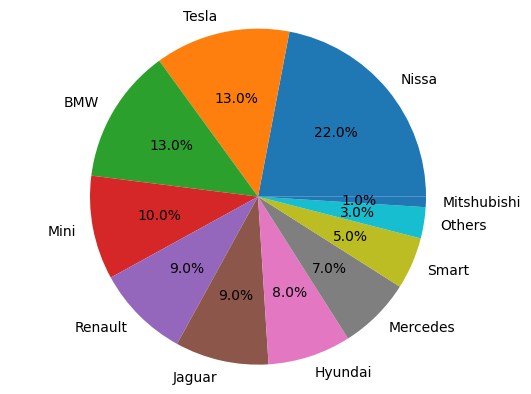

In [101]:
# Plot the population brand in a pie chart

# Values of each group
brand_values = aggregator.population_dataframe()['brand'].value_counts()
plt.pie(brand_values, labels=brand_values.index, autopct='%1.1f%%')

# View the plot
plt.axis('equal')
plt.show()